# Term Project

## Gemstone Predictions

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime

import PIL
import PIL.Image
import pathlib

from matplotlib import pyplot as plt
import matplotlib as mpl
import tensorflow as tf

from sklearn.metrics import confusion_matrix
import seaborn as sns

print(tf.__version__)

2.10.0


In [3]:
print(tf.config.list_physical_devices('GPU'))
print(tf.test.is_built_with_cuda)
print(tf.test.gpu_device_name())
print(tf.config.get_visible_devices())

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("Is Built With CUDA: ", tf.test.is_built_with_cuda())
print("CUDA GPU Name: ", tf.test.gpu_device_name())

import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


[]
<function is_built_with_cuda at 0x000002678D27DF70>

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Num GPUs Available:  0
Is Built With CUDA:  False
CUDA GPU Name:  
Please install GPU version of TF


#### Parameters

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

In [5]:
batch_size = 16
img_height = 240
img_width = 240

#### Data

In [6]:
data_dirpathname = r'C:\Users\ehven\Documents\MS Data Science\Sem 2\ECE565 - Machine Learning\projects\Final Folder\dataset-processed'
data_dir = pathlib.Path(data_dirpathname)

class_names = os.listdir(data_dir)
num_classes = len(class_names)

Code that will count number of classes
## Number of images in each class

In [7]:
images_per_class = {}
for class_name in class_names:
    images_per_class[class_name] = len(os.listdir(os.path.join(data_dir, class_name)))

print("Number of classes:", num_classes)
print("Number of images in each class:", images_per_class)

Number of classes: 88
Number of images in each class: {'Alexandrite': 50, 'Almandine': 50, 'Amazonite': 50, 'Amber': 50, 'Amethyst': 50, 'Ametrine': 50, 'Andalusite': 50, 'Andradite': 50, 'Aquamarine': 50, 'Aventurine Green': 50, 'Aventurine Yellow': 50, 'Benitoite': 50, 'Beryl Golden': 50, 'Bixbite': 50, 'Bloodstone': 50, 'Blue Lace Agate': 50, 'Brazilianite': 50, 'Carnelian': 50, 'Cats Eye': 50, 'Chalcedony': 50, 'Chalcedony Blue': 50, 'Chrome Diopside': 50, 'Chrysoberyl': 50, 'Chrysocolla': 50, 'Chrysoprase': 50, 'Citrine': 50, 'Coral': 50, 'Danburite': 50, 'Diamond': 50, 'Diaspore': 50, 'Dumortierite': 50, 'Emerald': 50, 'Fluorite': 50, 'Garnet Red': 50, 'Goshenite': 50, 'Grossular': 50, 'Hessonite': 50, 'Hiddenite': 50, 'Iolite': 50, 'Jade': 50, 'Jasper': 50, 'Kunzite': 50, 'Kyanite': 50, 'Labradorite': 50, 'Lapis Lazuli': 50, 'Larimar': 50, 'Malachite': 50, 'Moonstone': 50, 'Morganite': 50, 'Onyx Black': 50, 'Onyx Green': 50, 'Onyx Red': 50, 'Opal': 50, 'Pearl': 50, 'Peridot': 50

In [8]:
image_count =  len(list(data_dir.glob('*/*.jpg')))
print('Image count:', image_count)

Image count: 4400


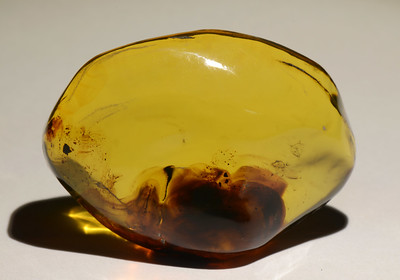

In [9]:
one = list(data_dir.glob('Amber/*'))
PIL.Image.open(str(one[0]))

In [10]:
sample_image = PIL.Image.open(str(one[1]))
img = np.asarray(sample_image)
img.shape

(400, 400, 3)

#### Setup Dataset Pipeline

In [11]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)
list_ds

<ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [12]:
for f in list_ds.take(5):
    print(f.numpy())

b'C:\\Users\\ehven\\Documents\\MS Data Science\\Sem 2\\ECE565 - Machine Learning\\projects\\Final Folder\\dataset-processed\\Benitoite\\benitoite_28.jpg'
b'C:\\Users\\ehven\\Documents\\MS Data Science\\Sem 2\\ECE565 - Machine Learning\\projects\\Final Folder\\dataset-processed\\Dumortierite\\dumortierite_41.jpg'
b'C:\\Users\\ehven\\Documents\\MS Data Science\\Sem 2\\ECE565 - Machine Learning\\projects\\Final Folder\\dataset-processed\\Amethyst\\amethyst_9.jpg'
b'C:\\Users\\ehven\\Documents\\MS Data Science\\Sem 2\\ECE565 - Machine Learning\\projects\\Final Folder\\dataset-processed\\Quartz Rutilated\\quartz rutilated_43.jpg'
b'C:\\Users\\ehven\\Documents\\MS Data Science\\Sem 2\\ECE565 - Machine Learning\\projects\\Final Folder\\dataset-processed\\Cats Eye\\cats eye_0.jpg'


## Data must be split in train/test and validation set

In [13]:
test_size = int(image_count*0.2)
train_ds = list_ds.skip(test_size)
val_ds = list_ds.take(test_size)

In [14]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

3520
880


#### Helper Functions

In [15]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names
    return tf.argmax(one_hot)

In [16]:
def decode_img(img):
    img = tf.io.decode_jpeg(img, channels=3)
    return tf.image.resize(img, [img_height, img_width])

In [17]:
def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [18]:
# Set 'num_parallel_calls' so multiple images are loaded/processed in parallel.

train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

## Image resized to 240x240xNo_Of_channels.

## Automatic data label extraction based on sub-directory name.

## Display one batch of image/label using the dataset api.

In [19]:
for image, label in train_ds.take(1):
    print("Image shape:", image.numpy().shape)
    print("Label:", class_names[label.numpy()])

Image shape: (240, 240, 3)
Label: Sodalite


In [20]:
def configure_for_performance(ds):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size=64)
    return ds

In [21]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

#### Test Dataset Pipeline

In [22]:
image_batch, label_batch = next(iter(train_ds))

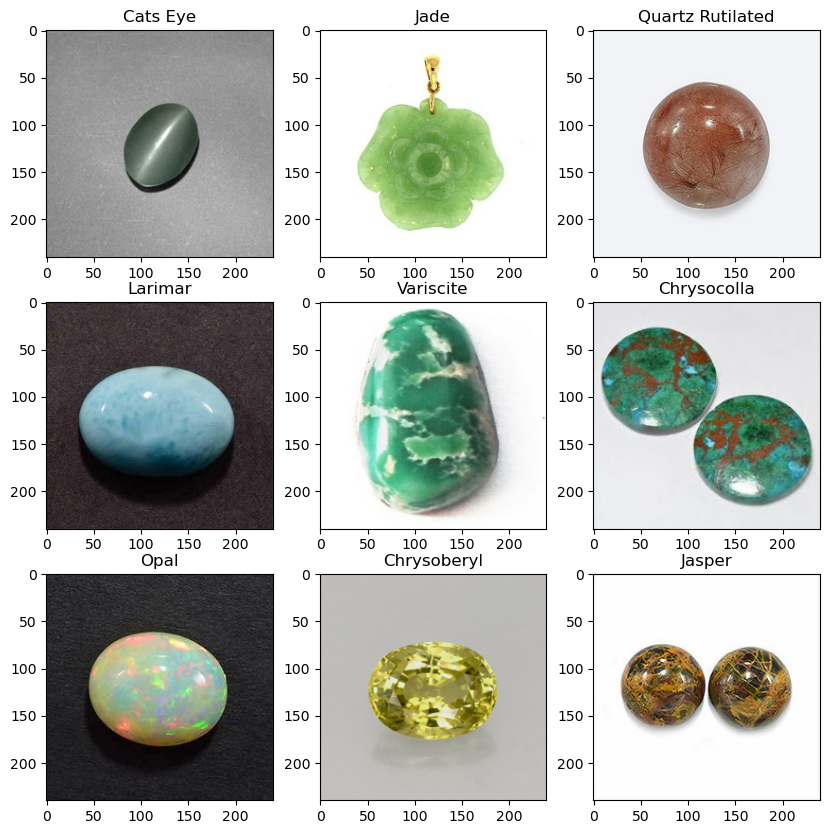

In [23]:
plt.figure(figsize=(10,10))
for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    label = label_batch[i]
    plt.title(class_names[label])

## Model

In [24]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(img_height, img_width, 3), name='Input_Shape_Layer'),
    tf.keras.layers.Rescaling(1./255),  # Normalize pixel values
    tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

In [25]:
# tf.keras.utils.plot_model(model=model, rankdir="LR", dpi=72, show_shapes=True)

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

### Training / Validation Cycle

In [27]:
logdir = "logs_temp/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

## Train/Validation

### Early stopping

In [28]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=2)

In [29]:
model.fit(
    train_ds,
    validation_data=val_ds, 
    epochs=101,
    callbacks=[tensorboard_callback, early_stopping_callback],
    verbose=1
)

Epoch 1/101
55/55 [==============================] - 42s 751ms/step - loss: 5.5647 - accuracy: 0.0503 - val_loss: 3.7161 - val_accuracy: 0.1114
Epoch 2/101
55/55 [==============================] - 40s 735ms/step - loss: 2.8915 - accuracy: 0.2381 - val_loss: 2.5798 - val_accuracy: 0.2932
Epoch 3/101
55/55 [==============================] - 43s 776ms/step - loss: 1.7787 - accuracy: 0.4869 - val_loss: 2.3107 - val_accuracy: 0.3420
Epoch 4/101
55/55 [==============================] - 41s 742ms/step - loss: 1.1011 - accuracy: 0.6864 - val_loss: 2.1352 - val_accuracy: 0.4352
Epoch 5/101
55/55 [==============================] - 42s 761ms/step - loss: 0.5456 - accuracy: 0.8443 - val_loss: 2.1306 - val_accuracy: 0.4534
Epoch 6/101
55/55 [==============================] - 42s 763ms/step - loss: 0.2670 - accuracy: 0.9366 - val_loss: 2.3057 - val_accuracy: 0.4409
Epoch 7/101
55/55 [==============================] - 41s 742ms/step - loss: 0.1414 - accuracy: 0.9682 - val_loss: 2.4495 - val_accuracy:

## Model Evaluation

## Accuracy Metrics

In [30]:
test_loss, test_acc = model.evaluate(val_ds, verbose=2)
print('\nTest Accuracy:', test_acc)

14/14 - 3s - loss: 2.4495 - accuracy: 0.4534 - 3s/epoch - 188ms/step

Test Accuracy: 0.4534091055393219


In [31]:
all_predictions = []
all_labels = []

## Confusion Matrix

In [32]:
for images, labels in val_ds:
    predictions = model.predict(images)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = labels.numpy()

    all_predictions.extend(predicted_classes)
    all_labels.extend(true_classes)

2/2 [==============================] - 0s 70ms/step


In [33]:
cm = confusion_matrix(all_labels, all_predictions)
class_names_array = np.array(class_names)

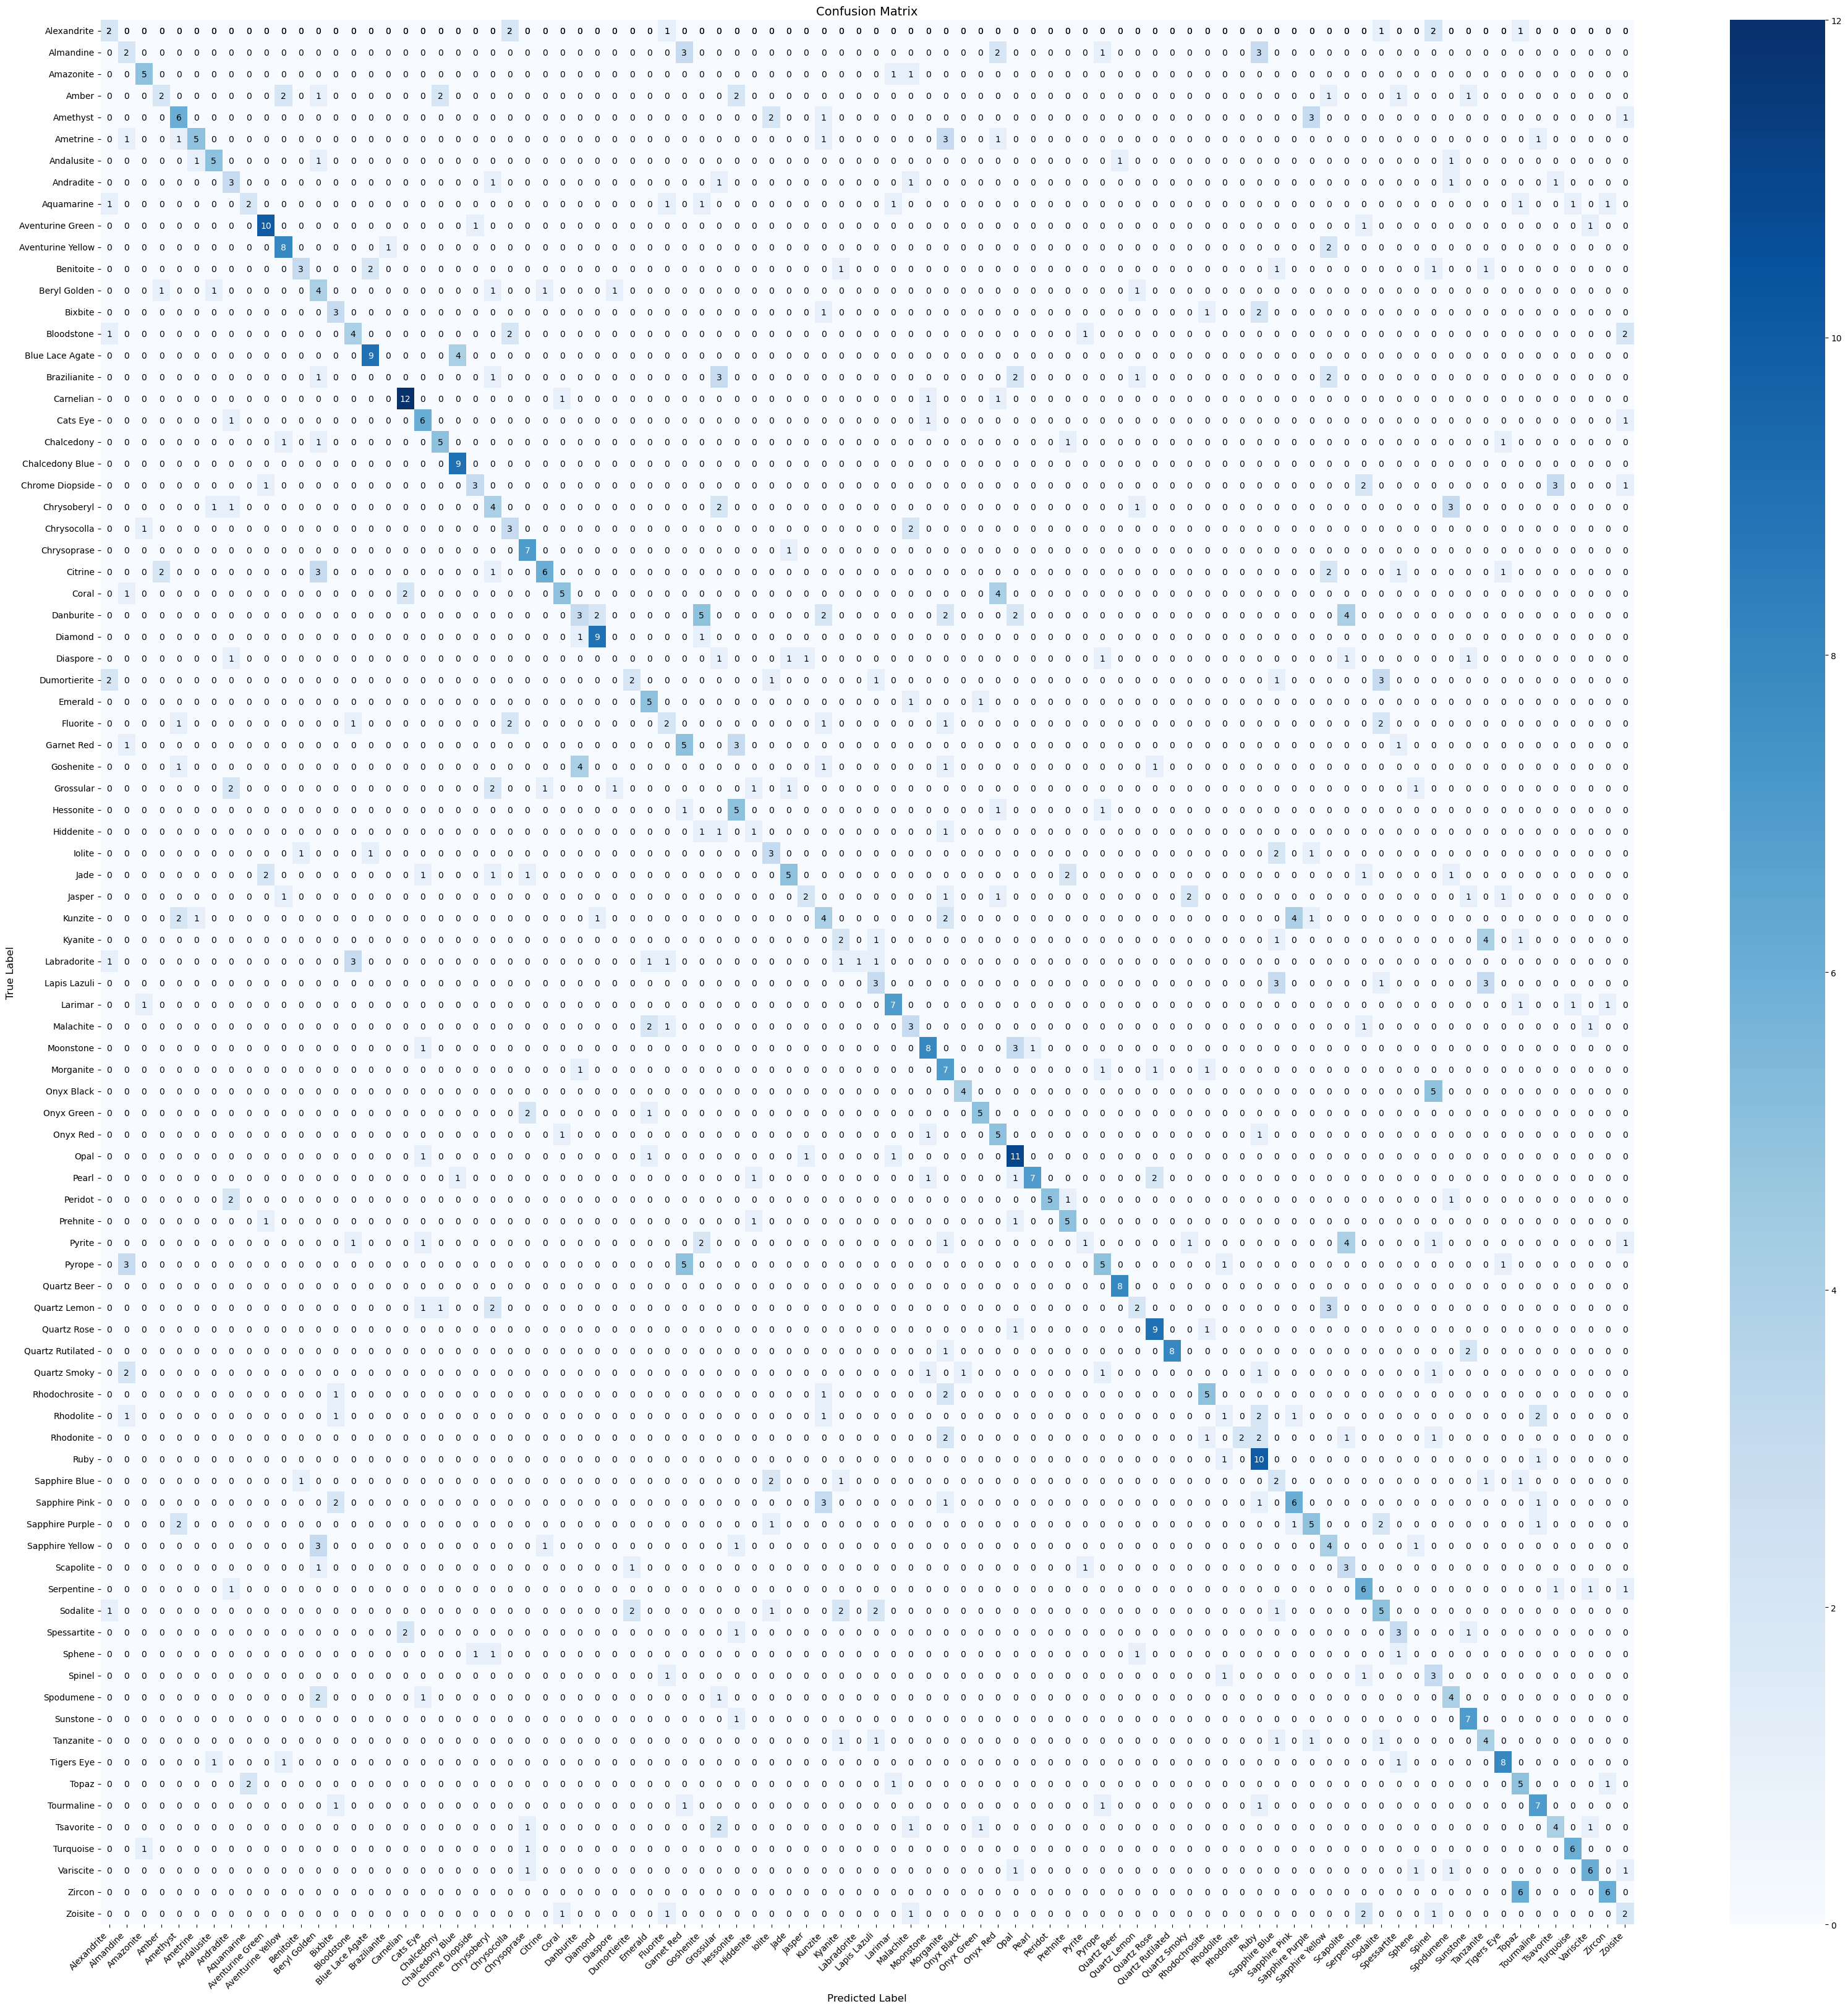

In [34]:
plt.figure(figsize=(40, 40))  # Increase figure size to make room for labels
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                 xticklabels=class_names, yticklabels=class_names)

# Set tick labels appearance
plt.xticks(rotation=45, ha='right', fontsize=10)  # Adjust font size or rotation as needed
plt.yticks(fontsize=10)

# Colorbar label and title
plt.title('Confusion Matrix', fontsize=14)  # Increase title font size
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Loop over data dimensions and create text annotations with contrasting colors
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j+0.5, i+0.5, format(cm[i, j], 'd'),
                ha='center', va='center',
                color='white' if cm[i, j] > thresh else 'black')

plt.show()

#### Make Predictions

In [35]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])

In [36]:
predictions = probability_model.predict(val_ds)

14/14 [==============================] - 3s 178ms/step


In [37]:
predictions[0]

array([0.01119363, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.0111934 ,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.01483988,
       0.01119333, 0.01119333, 0.01119333, 0.01119345, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.02211316, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01121076, 0.01119334, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.0111935 , 0.01119333,
       0.01119333, 0.01152493, 0.01119333, 0.01119333, 0.01119336,
       0.01126021, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119333, 0.01119333, 0.01119333,
       0.01119333, 0.01119333, 0.01119335, 0.01119333, 0.01119

In [38]:
class_names[np.argmax(predictions[0])]

'Chrysocolla'

In [39]:
image_batch, label_batch = next(iter(val_ds))

In [40]:
label_batch

<tf.Tensor: shape=(64,), dtype=int64, numpy=
array([26, 19, 25,  2, 79, 68, 30,  6, 48, 57, 25,  8, 57, 85, 60, 16, 18,
       39, 67, 72, 86, 17,  1, 67, 53, 43,  0, 57, 53, 82, 34, 68, 68, 47,
       28,  6, 23,  0, 66, 53, 86, 66,  3, 12, 17, 22, 64, 21, 82, 12, 15,
       41, 46, 10, 48, 39, 29, 21, 83, 17, 10, 15, 30, 52], dtype=int64)>

In [41]:
predictions = probability_model.predict(image_batch)

2/2 [==============================] - 0s 91ms/step


In [42]:
np.argmax(predictions, axis=1)

array([17, 10,  3,  2, 79, 41, 38, 77, 48, 57, 12, 34, 33, 85, 60, 22, 18,
        9, 81, 72, 81, 26,  1, 38, 52, 31, 76,  1, 53, 57, 60, 68, 68, 47,
       28,  6, 46,  0, 66, 20, 81, 66, 78, 12, 17, 22, 68, 72, 82, 12, 15,
       41, 46, 16, 48, 39, 40, 87, 35, 17, 10, 20, 30, 52], dtype=int64)

In [43]:
image_batch[0].shape

TensorShape([240, 240, 3])

In [44]:
predictions_prob = probability_model.predict(image_batch)
predictions = np.argmax(predictions_prob, axis=1)

2/2 [==============================] - 0s 83ms/step


## Model Predictions

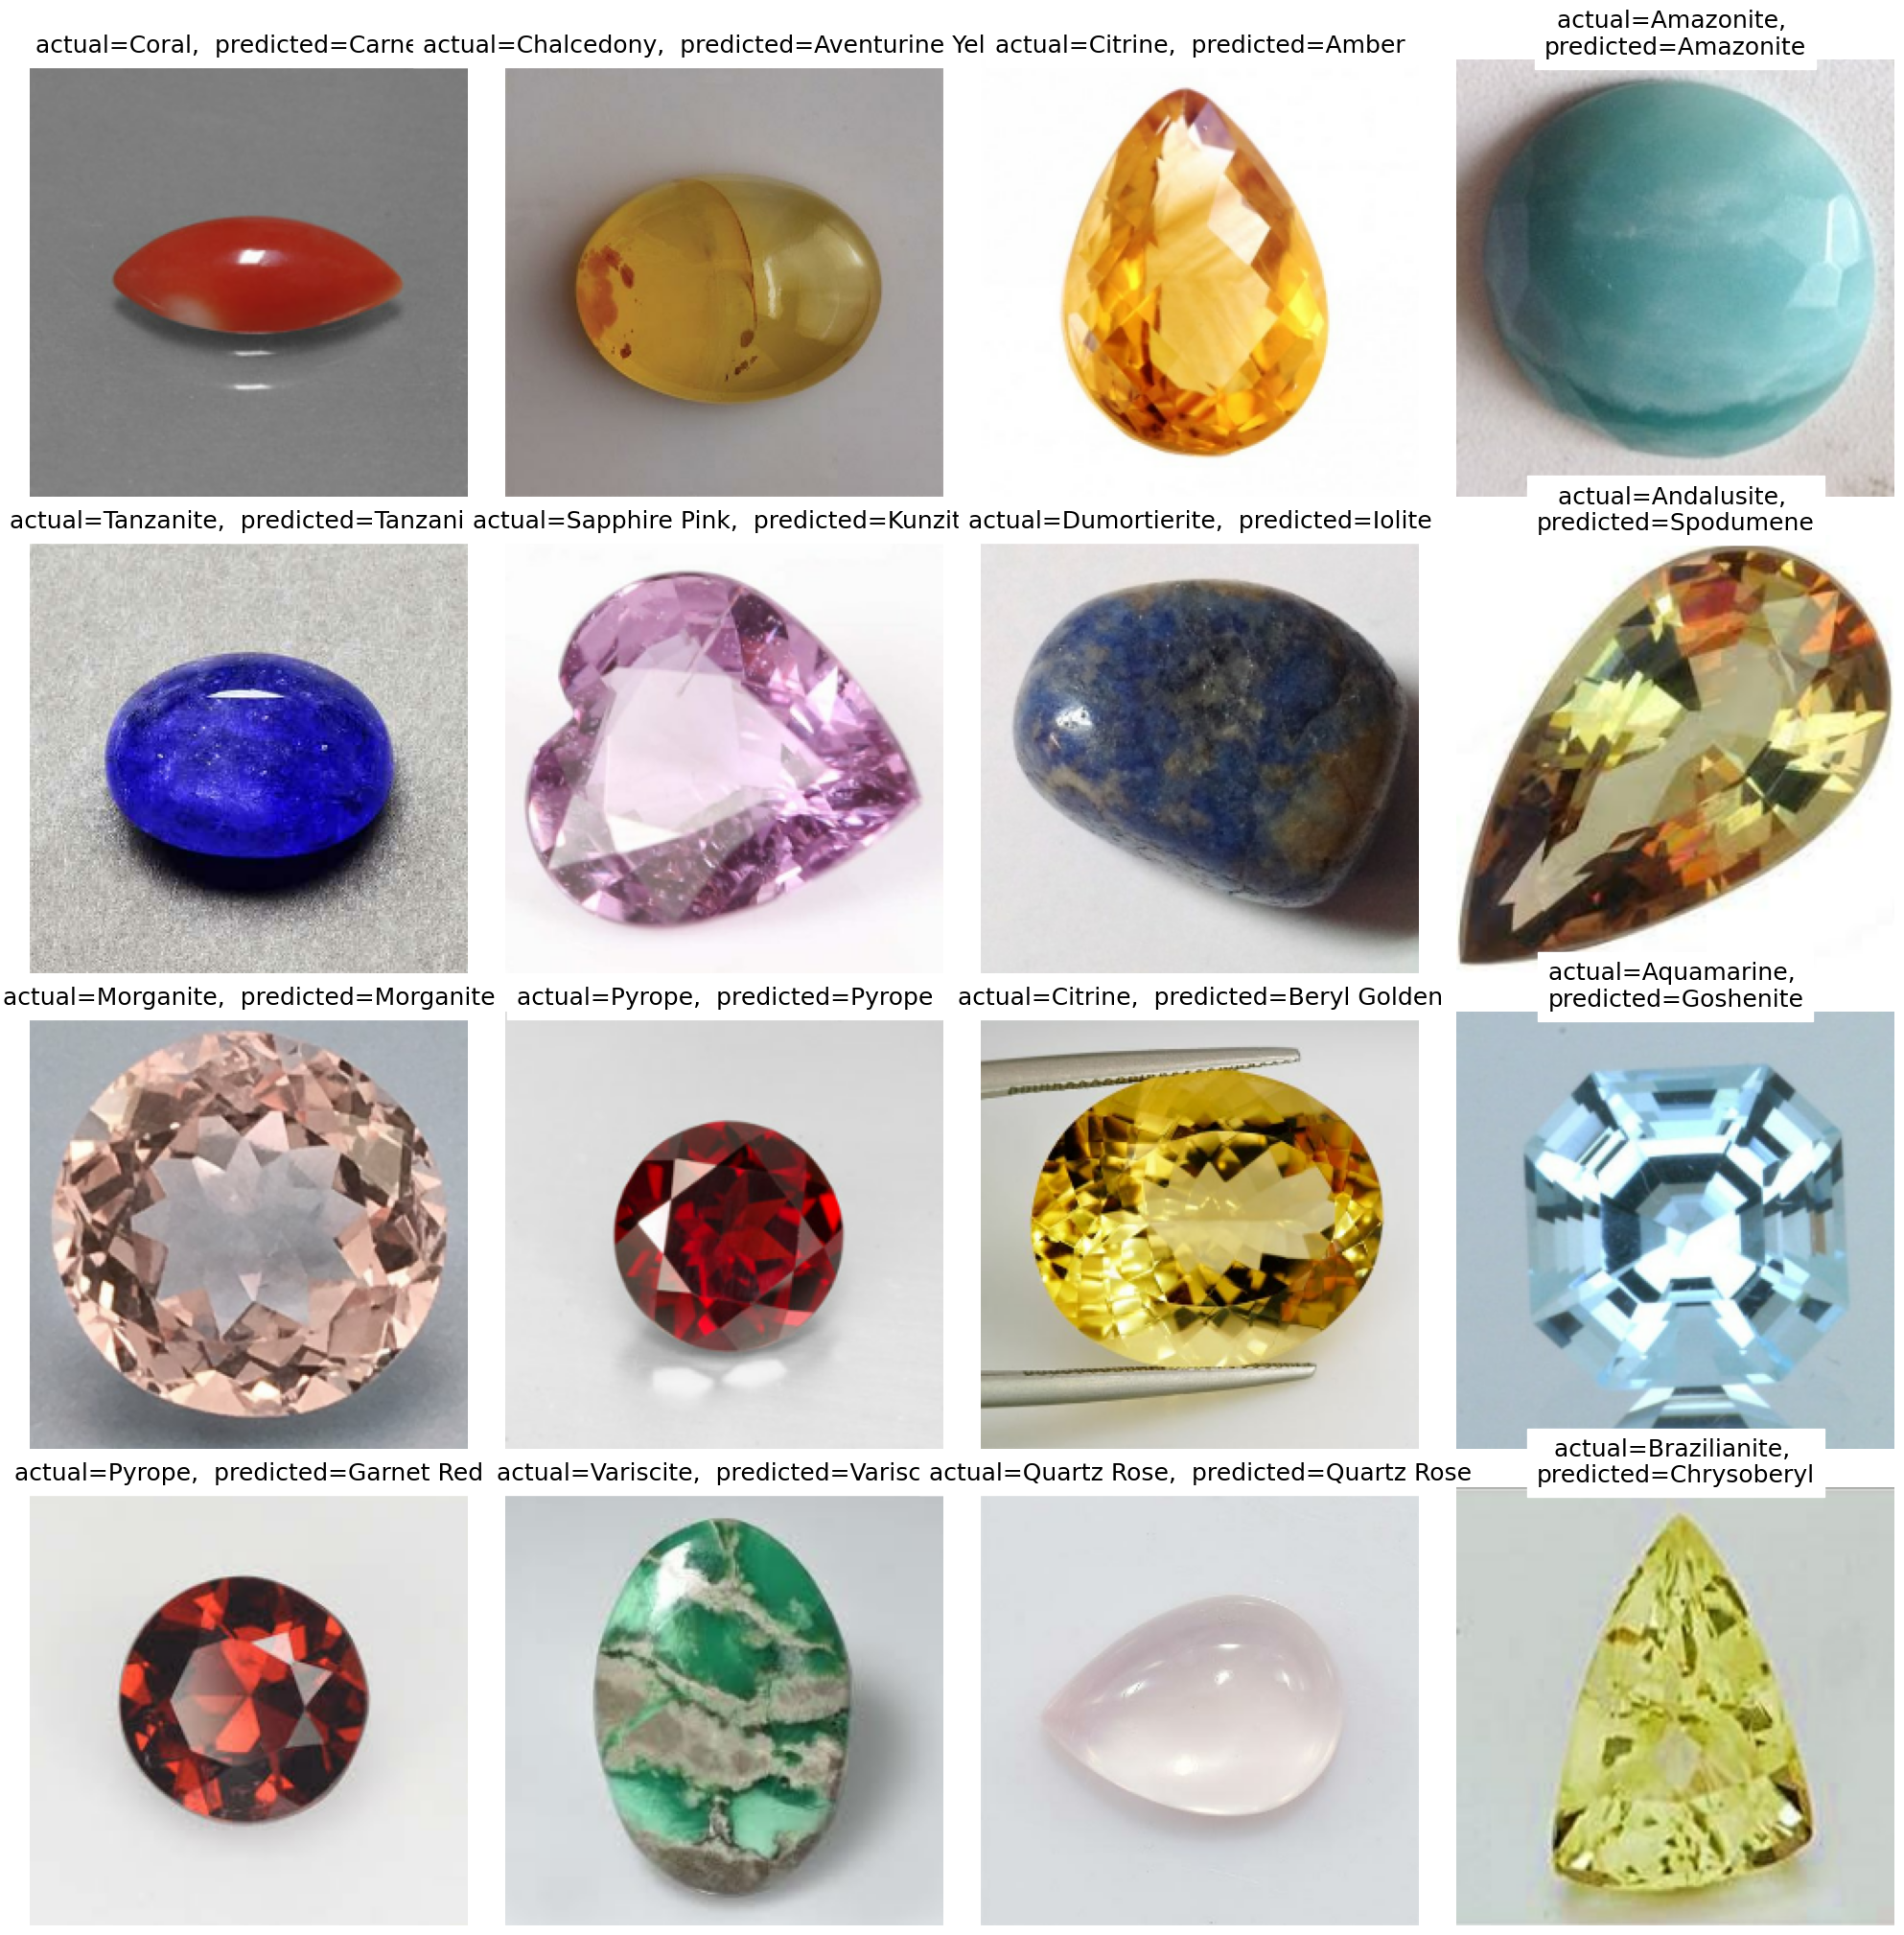

In [45]:
plt.figure(figsize=(20, 20))
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.titlepad'] = 5

for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    true_label = class_names[label_batch[i]]
    predicted_label = class_names[predictions[i]]
    title_text = f'actual={true_label},  predicted={predicted_label}'
    plt.title(title_text, wrap=True, backgroundcolor='white', fontsize=18) 
    plt.axis('off')

plt.tight_layout(pad=1.0)
plt.show()

# Exporting the model and weights

In [46]:
# Save the entire model as a SavedModel.
model.save('project_model')

# Optionally, you can save just the weights
model.save_weights('project_model.h5')

INFO:tensorflow:Assets written to: project_model\assets


INFO:tensorflow:Assets written to: project_model\assets


## Tensorboard

In [47]:
%load_ext tensorboard
%tensorboard --logdir {logdir}